In [1]:
%matplotlib inline

In [2]:
# load packages
import matplotlib.pylab as plt
import numpy as np
import time
def myfloat(b):
    try: 
        b = float(b)
    except ValueError:
        b = [b for b in b.split('-').split('+') if b]
        b = float(b[0])*10**(-float(b[1]))
    return b


In [60]:
ncol = 20
nrow = 100
tmax = 100.
dt = .05
nprt =  int(tmax/100/dt)
slope = 30.
epsh = 0.001
dx = .1
hinit = 0.01
prate  = 0.07/3600.
xni = 0.03  # interspace roughness
ksati =  0.0 #0.019/3600.  # interspace ksat
Soi = .0   # interspace sorptivity (m/s)

In [61]:
def write_coords(fname = 'coords', ncol = ncol, nrow = nrow, dx = dx, 
                 slope = slope, xni = xni, ksati = ksati, Soi = Soi):        
    npt = (ncol+1)*(nrow+1)  # number of points
    ne = nrow*ncol  # number of edges
    nbcell = 2*ncol + 2*nrow - 4  # number of boundary cells

    xdum = np.arange(1, (ncol+1)*dx+1 - 1e-10, dx )
    ydum = np.arange(1, (nrow+1)*dx+1 - 1e-10, dx )
    ydum, xdum = np.meshgrid(ydum, xdum)

    zmax = slope/100.*(np.max(ydum) - np.min(ydum))
    zdum = np.linspace(0, zmax, nrow+1)
    zdum = np.tile(zdum, [ncol+1]).reshape([ncol+1, nrow+1])
    
    xndum = np.ones_like(zdum)*xni    
    # xndum[:, :40]  = 0.1
    
    ksat_dum = np.ones_like(zdum)*ksati    
    Sodum = np.ones_like(zdum)*Soi    
    
    x = np.zeros(npt + 1)
    y = np.zeros(npt + 1)
    z = np.zeros(npt + 1)
    xn = np.zeros(npt + 1)
    satk = np.zeros(npt + 1)
    So = np.zeros(npt + 1)
    x[1:] = xdum.ravel()
    y[1:] = ydum.ravel()
    z[1:] = zdum.ravel()
    xn[1:] = xndum.ravel()
    satk[1:] = ksat_dum.ravel()
    So[1:] = Sodum.ravel()

    # print (np.max(zdum) - np.min(zdum))/(np.max(ydum) - np.min(ydum))*100
    # (ncol+1) by (nrow+1)  -  node numbers
    nodes = np.arange(1, npt+1, dtype = int).reshape([ncol+1, nrow+1])

    nop = np.zeros([ncol+1, nrow+1, 4], dtype = int)
    for j in range(ncol):
        for k in range(nrow):
            nop[j+1, k+1] =  nodes[j,k], nodes[j+1, k], nodes[j+1,k+1], nodes[j,k+1]
            
    f = open(fname, 'w')
    f.write('{0:<13}   {1:<13}\n'.format(npt, ne))

    # write x, y, z
    for n in range(1, npt+1):
        f.write('{0:<13.6f} {1:<13.6f} {2:<13.6f} {3:<13.6e} {4:<13.6e} {5:<13.6e} \n'.format(
                    x[n],y[n],z[n],xn[n],satk[n],So[n])) 

    # write node numbers  
    for j in range(1, ncol+1):
        for k in range(1, nrow+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3] 
            f.write('{0:<10} {1:<10}  {2:<10} {3:<10}\n'.format(n1, n2, n3, n4)) 
    f.close()  

    # get cell center values:
    xcc  = np.zeros([ncol+2, nrow+2])    
    ycc  = np.zeros([ncol+2, nrow+2])
    zcc  = np.zeros([ncol+2, nrow+2])
    xncc  = np.zeros([ncol+2, nrow+2])
    satkc = np.zeros([ncol+2, nrow+2])
    Soc = np.zeros([ncol+2, nrow+2])    
    for j in range(1, ncol+1):
        for k in range(1, nrow+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3]  
            xcc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
            ycc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
            zcc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])   
            xncc[j,k] = 0.25*(xn[n1] + xn[n2] + xn[n3] + xn[n4])   
            satkc[j,k] = 0.25*(satk[n1] + satk[n2] + satk[n3] + satk[n4])   
            Soc[j,k] = 0.25*(So[n1] + So[n2] + So[n3] + So[n4])   
    return  nop, x, y, z, xcc, ycc, zcc, xncc, satk, Soc


In [62]:
def write_dryin(fname = 'dryin.dat', ncol = ncol, nrow = nrow, dt = dt, 
                 tmax = tmax, prate = prate, nprt = nprt, epsh = epsh,
                 hinit = hinit):
    inum = np.zeros([ncol+1, nrow+1], dtype = int)
    inum[1:, 1] = 1
    inum[1:, -1]= 1
    inum[1, 1:] = 1
    inum[-1, 1:] = 1
    inum[1, 1] = 2
    inum[1, -1] = 2
    inum[-1, -1] = 2
    inum[-1, 1] = 2
    
    ipos = np.zeros( [ncol+1, nrow+1, 2], dtype = int)
    # bottom boundary
    ipos[2:-1, 1,0] = 1
    ipos[1, 1,1] = 1
    ipos[-1, 1,1] = 1

    # right boundary
    ipos[-1, 1:-1, 0] = 2
    ipos[-1, -1,1] = 2

    # left boundary
    ipos[1, 1:, 0] = 4

    # top boundary
    ipos[2:, -1,0] = 3
    ipos[1, -1,1] = 3
    
    itype = np.zeros([ncol+1, nrow+1, 2], dtype = int)
    # bottom boundary
    itype[2:-1, 1,0] = 0
    itype[1, 1,1] = 0
    itype[-1, 1,1] = 0

    # right boundary
    itype[-1, 1:-1, 0] = 1
    itype[-1, -1,1] = 1

    # left boundary
    itype[1, 1:,0] = 1

    # top boundary
    itype[2:, -1,0] = 1
    itype[1, -1,1] = 1
    
    npt = (ncol+1)*(nrow+1)  # number of points
    ne = nrow*ncol  # number of edges
    nbcell = 2*ncol + 2*nrow - 4  # number of boundary cells

    f = open(fname, 'w')
    f.write('gravity     dt        tmax      xsplit   \n')
    f.write('9.806d0     {0}       {1}     100.d0   \n'.format(dt, tmax))
    f.write(' epsh        beta       prate \n')  
    f.write('{0}d0     2.d0       {1:6e}  \n'.format(epsh, prate))
    #     f.write('0.0025d0    2.d0   {0}d0 \n'.format(prate))
    f.write('xk          ainflt       binflt           tc           cappa \n')
    # xk = 3.9217d-4
    f.write('3.9217d-4   0.5d0       2.65d-7          0.d0        0.99d0 \n')
    f.write('istart     imass      ifront         print interval  \n')
    f.write(' 0         1          1               {0} \n'.format(nprt))
    f.write('number of boundary cell \n') 
    f.write('  {0} \n'.format(nbcell))
    f.write(' j    k          inum    itype             ipos \n')
    # f.write(' j \t k \tinum    itype \t\t ipos')
    j = 1
    for k in range(1, nrow+1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    for j in range(2, ncol+1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    for k in range(nrow-1,0,-1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))
            
    for j in range(ncol-1,1,-1):
        if inum[j, k] == 2:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<8} {4:<9} {5:<8} {6:<6} \n'.format(
                        j, k, inum[j, k], itype[j, k, 0], itype[j, k, 1], 
                         ipos[j, k, 0], ipos[j, k, 1]))
        else:
            f.write( '{0:<5} {1:<13} {2:<7} {3:<18} {4:<10}   \n'.format(
                         j, k, inum[j, k],  itype[j, k, 0],  ipos[j, k, 0], ))

    kbeg = np.ones(ncol+1, dtype = int)
    kend = np.ones(ncol+1, dtype = int)*nrow
   
    f.write('ncol\n')
    f.write("{0}\n".format(ncol))
    f.write('j     kbeg          kend \n')
    for j in range(1, ncol+1):
        f.write( '{0:>5}  {1:>5} {2:>13}   \n'.format(
                    j, kbeg[j],kend[k] ))

    f.write('h0l      u0l    v0l   \n ')
    f.write('{0}d0     0.0    0.0  \n '.format(hinit))
    f.write('h0r      u0r    v0r  \n ')
    f.write('{0}d0     0.0    0.0  \n '.format(hinit))
    f.close()
    return inum, ipos, itype

In [63]:
from commands import getoutput as cmd
cmd("gfortran dryt.for")

''

In [64]:
tmax = 100.
epshs = [0.001, .002, .005, .01, .02, .1] 
tmaxes = []
cfls = []
runtimes = []

for e, epsh in enumerate(epshs):
    start_time = time.time()
    inum, ipos, itype = write_dryin(fname = 'dryin.dat', 
                                    epsh = epsh, hinit = .001)
    nop, x, y, z, xc, yc, zc, xnc, satkc, Soc = write_coords(
        fname='coords', slope = slope)
    a = cmd("./a.out")
    t = []
    f =  open("output/time.out", 'r')
    f.next()
    for line in f:
        a = (line.strip().split(" "))
        a = [b for b in a if b]
        t.append(float(a[0]))

    tmaxes.append(t[-1])
    
    f =  open("output/cfl.out", 'r')
    cfl = []
    ta = []
    for line in f:
        a = line.strip().split(" ")
        a = [np.float(b) for b in a if b]
        ta.append(a[0])
        cfl.append(a[1])

    cfls.append(np.max(np.array(cfl)))
    runtimes.append( (time.time() - start_time))
    print t[-1], 

16.4 100.05 100.05 100.05 100.05 100.05


In [65]:
import pandas as pd
cols = pd.Series(['{0:.3f} '.format(dum) for dum in epshs], name = 'epsh')

df = pd.DataFrame({'tmax': ['{0:.1f}'.format(dum) for dum in tmaxes],  
              'runtime': ['{0:.2f}'.format(dum) for dum in runtimes],
              'CFL': ['{0:.2f}'.format(dum) for dum in cfls]},
               index = cols).T

In [66]:
fldrstr = "slope={1:.2f} prate={2:.1e} dx={3:.1} dt={0:.2f}".format( dt, slope,prate*100, dx)

fldrstr = "slope={1:.1f} prate={2:.1f} dx={3} h0={0:.1f}".format( hinit, slope,prate*100, dx)
fmtstr = "xn={1}".format( epsh, xni)
print  fldrstr, fmtstr
df

slope=30.00 prate=1.9e-03 dx=0.1 dt=0.05 xn=0.03


epsh,0.001,0.002,0.005,0.010,0.020,0.100
CFL,1.15,0.88,0.08,0.08,0.08,0.08
runtime,0.65,3.11,2.98,2.98,2.99,2.95
tmax,16.4,100.0,100.0,100.0,100.0,100.0


## Archive below this point

In [67]:
# read time output
t = []
itp = []  #  print step
it = []   #  time step
f =  open("output/time.out", 'r')
f.next()
for line in f:
    a = (line.strip().split(" "))
    a = [b for b in a if b]
    t.append(float(a[0]))
    itp.append(int(a[1]))
    it.append(int(a[2]))
ntstep = len(itp)
tmax = t[-1]
t = np.array(t)

In [68]:
fldrstr = "slope={1:.1f} prate={2:.1f} dx={3} dt={0:.1f}".format( dt, slope,prate*100, dx)
fmtstr = "ncol={0} ".format( ncol)
print fmtstr, fldrstr

ncol=20  slope=30.0 prate=0.0 dx=0.1 dt=0.1


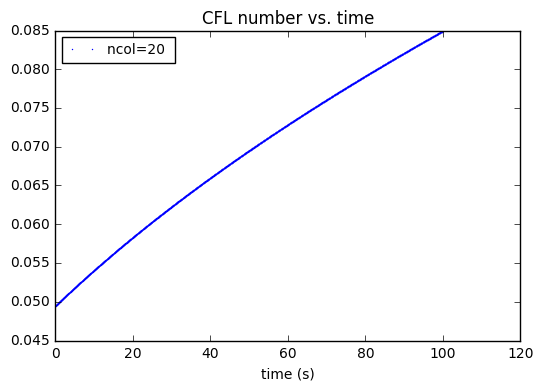

In [69]:
f =  open("output/cfl.out", 'r')
cfl = []
ta = []
for line in f:
    a = line.strip().split(" ")
    a = [np.float(b) for b in a if b]
    ta.append(a[0])
    cfl.append(a[1])
cfl =  np.array(cfl)

f =plt.figure()
yy = np.arange(nrow)
plt.plot(ta,  cfl, '.', ms = 1, label = fmtstr)
plt.legend(loc = 'best', fontsize = 10)
plt.title('CFL number vs. time')
plt.xlabel('time (s)')
f.savefig('plots/CFL {0}.pdf'.format(fmtstr))

In [70]:
h = []
hdum =  np.zeros([ncol+2, nrow+2])

for line in open("output/h.out", 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    try:
        j = int(a[0])
        k = int(a[1])
        hdum[j, k] = a[2]

    except IndexError:
        dumt = int(a[0])
        h.append(hdum.copy())

h = np.array(h)

if len(h)!= ntstep:
    print "wrong shape"

wrong shape


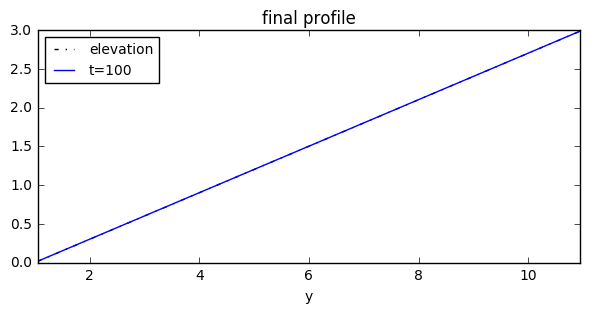

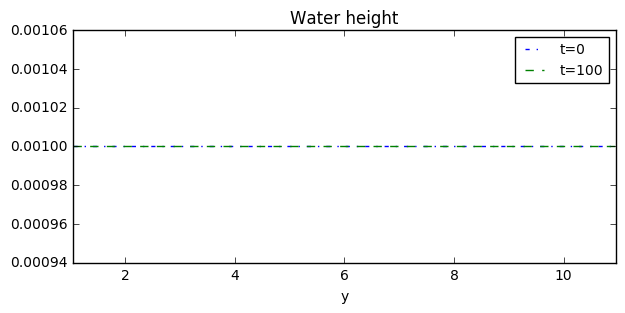

In [71]:
col = 5
yy = yc[col,1:-1 ]

f = plt.figure(figsize= (7,3))
plt.plot(yy, zc[col, 1:-1], 'k-.',  label = 'elevation')
plt.plot(yy, (zc + h[-1])[col, 1:-1], '-', label = 't={0:.0f}'.format(t[-1]) )
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('y'); plt.xlim(yc[col,1],yc[col,-2 ] )
plt.title('final profile')
f.savefig('plots/height {0}.pdf'.format(fmtstr))

f = plt.figure(figsize= (7,3))
yy = yc[col,1:-1 ]
plt.plot(yy, ( h[0])[col, 1:-1], '-.', label = 't={0:.0f}'.format(t[0]) )
plt.plot(yy, ( h[-1])[col, 1:-1], '--', label = 't={0:.0f}'.format(t[-1]) )
plt.legend(loc = 'best', fontsize = 10)
plt.xlabel('y'); plt.xlim(yc[col,1],yc[col,-2 ] ); 
# plt.xlabel('height (m)'); plt.ylim(np.min(h[:,1:-1,1:-1]-.1),np.max(h) +.1); 
plt.title('Water height')
f.savefig('plots/profile {0}.pdf'.format(fmtstr))

ValueError: x and y must have same first dimension

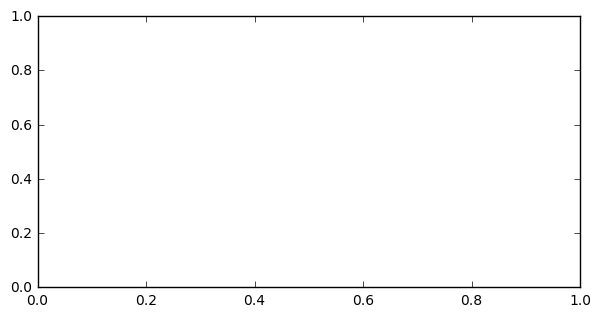

In [72]:
fig = plt.figure(figsize= (7,3.5))
yy = np.arange(nrow)
plt.plot(t,  h[:,col, 1], '-', label = 'y={0:.0f}'.format(yc[col, 1]))
plt.plot(t,  h[:,col, nrow], '-', label = 'y={0:.0f}'.format(yc[col, nrow]))
# plt.plot(t, 1 - Soi*t**.5 - ksati*t, '.')
plt.legend(loc = 'best', fontsize = 10)
plt.title('water height vs. time')
plt.xlabel('time (s)')
# f.savefig('plots/h {0}.pdf'.format(fmtstr))

In [ ]:
ta = []
dvol = []
infl = [] 
flux = []
dts = []
f = open('output/dvol.out', 'r'); 
for line in f:
    a = (line.strip().split(" "))
    a = [myfloat(b) for b in a if b]
    ta.append(a[0])
    dvol.append(a[1])
    flux.append(a[2])
    infl.append(a[3])
    dts.append(a[4])
ta = np.array(ta)
dvol = np.array(dvol)
flux = np.array(flux)
infl = np.array(infl)
total = dvol  - flux - infl

In [ ]:
def get_dvol(fname):
    ta = []
    dvol = []
    infl = [] 
    flux = []
    dts = []
    f = open(fname, 'r'); 
    for line in f:
        a = (line.strip().split(" "))
        a = [myfloat(b) for b in a if b]
        ta.append(a[0])
        dvol.append(a[1])
        flux.append(a[2])
        infl.append(a[3])
        dts.append(a[4])
    ta = np.array(ta)
    dvol = np.array(dvol)
    flux = np.array(flux)
    infl = np.array(infl)
    total = dvol  - flux - infl
    return ta, dvol, flux, infl, dts, total

In [ ]:
# if prate > 0:
#     infl = infl - prate
#     precip = prate*np.ones(infl.shape)

In [ ]:
ta, dvol, flux, infl, dt_array, total  = get_dvol('output/dvol.out')

ti = 0; tf =len(ta)-1;  nprt = 10

f = plt.figure(figsize= (9,5.5))
plt.subplot(211)
plt.plot(ta[ti:tf:nprt], dvol[ti:tf:nprt] - flux[ti:tf:nprt] - infl[ti:tf:nprt], '.', ms = 2)
plt.title('mass balance (dV - fluxes - infiltration)', fontsize = 10)
plt.ylabel('volume (m$^3$)'); plt.xlim([ta[ti], ta[tf]])
plt.subplot(212)
plt.plot(ta[ti:tf:nprt],np.cumsum(total)[ti:tf:nprt], '.', ms = 2)
plt.title('cumulative mass balance', fontsize = 10)
plt.xlabel('time (s)'); plt.ylabel('volume (m$^3$)');
plt.xlim([ta[ti], ta[tf]])
plt.suptitle('{0}'.format(fmtstr  ))
f.savefig('plots/dV {0}.pdf'.format(fmtstr))

In [ ]:
def allfluxes():
    flux1 = [];
    flux2 = [];
    flux3 = [];
    flux4 = [];    
    f = open("output/allfluxes.out", 'r'); 
    for line in f:
        a = (line.strip().split(" "))
        a = [myfloat(b) for b in a if b]
        flux1.append(a[0])
        flux2.append(a[1])
        flux3.append(a[2])
        flux4.append(a[3])
    flux1 = np.array(flux1)
    flux2 = np.array(flux2)
    flux3 = np.array(flux3)
    flux4 = np.array(flux4)    
    return flux1, flux2, flux3, flux4

In [ ]:
flux1, flux2, flux3, flux4 = allfluxes()

In [ ]:
## all fluxes
# precip - positive, infl - negative
ta, dvol, flux, infl, dts, total  = get_dvol('output/dvol.out')

ti =1; tf = len(ta)+1;  nprt = 1

f = plt.figure(figsize= (7.5, 3))
plt.plot(ta[ti:tf:nprt], dvol[ti:tf:nprt]/dts[ti:tf:nprt], '.', ms = 1, label = 'dV')
plt.plot(ta[ti:tf:nprt], flux[ti:tf:nprt]/dts[ti:tf:nprt],'.', ms = 1, label = 'fluxes')
plt.plot(ta[ti:tf:nprt], infl[ti:tf:nprt]/dts[ti:tf:nprt],'.', ms = 1, label = 'infl+precip')
plt.title('Time step flux components ', fontsize = 11)
plt.ylabel('volume (m$^3$)')
plt.legend(loc = 'best', fontsize= 11)

f = plt.figure(figsize= (7.5, 3))
plt.plot(ta[ti:tf:nprt], np.cumsum(dvol)[ti:tf:nprt], '.', ms = 1, label = 'volume')
plt.plot(ta[ti:tf:nprt], np.cumsum(flux)[ti:tf:nprt], '.', ms = 1, label = 'fluxes')
plt.plot(ta[ti:tf:nprt], np.cumsum(infl)[ti:tf:nprt], '-', ms = 1, label = 'infl +precip')
plt.legend(loc = 'best', fontsize= 11)
plt.title('cumulative flux components', fontsize = 11)
plt.ylabel('volume (m$^3$)'); plt.xlabel('time (s)')
f.savefig('plots/fluxes {0}.pdf'.format(fmtstr))

In [ ]:
flux1 = []
# ts = []
fdum = np.zeros([95 ]) 

for line in open("output/fluxes.out", 'r'):
    a = (line.strip().split(" "))
    try:
        a = [str(b) for b in a if b]        
        j = int(a[0])
        k = int(a[1])
        fdum[j] = a[2]   
    except ValueError:
        dumt = int(a[0])
#       ts.append(float(a[1]))
        flux1.append(fdum.copy())
        fdum = np.zeros([95 ]) 
flux1 = np.array(flux1)
nfstep = len(flux1)      

In [ ]:
flux1.shape

In [ ]:
t.shape

In [ ]:
#  check influx again?
fig = plt.figure()
plt.plot(t,-flux1.sum(1), '.', ms = 3)
plt.title('Flux out; {0}'.format( fmtstr))
plt.xlabel('time'); plt.ylabel('m')
fig.savefig('plots/outflux_{0}.pdf'.format(fmtstr))

In [ ]:
f = open('total_fluxes.out\n', 'a')
f.write('cumulative infiltration = {0}\n'.format(np.cumsum(infl)[-1]))
f.write('cumulative volume change = {0}\n'.format(np.cumsum(dvol)[-1]))
f.write('cumulative volume change = {0}\n'.format(-np.cumsum(flux)[-1]))
f.close()